# Часть 1. Обучение базовой модели

1. Импортировать необходимые библиотеки и загрузить данные
2. Изучить и проанализировать данные (определить пропущенные значения,
основные статистики, типы данных и т.д.)
3. Создать пайплайн с использованием Pipeline и ColumnTransformer для
обработки пропущенных значений и преобразования категориальных признаков
(one-hot encoding, label encoding)
4. Разделить данные на обучающую и тестовую выборки

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.feature_selection import RFE
import seaborn as sns
from scipy import stats

In [ ]:
columns = ['age', 'workclass', 'fnlwgt', 'education',
'education-num', 'marital-status', 'occupation',
'relationship', 'race', 'sex', 'capital-gain',
'capital-loss', 'hours-per-week', 'native-country',
'income']
df = pd.read_csv('/content/drive/MyDrive/data/adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')

In [ ]:
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [ ]:
def column_summary(df):
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })

    summary_df = pd.DataFrame(summary_data)
    return summary_df



In [ ]:
summary_df = column_summary(df)
display(summary_df)

,col_name,col_dtype,num_of_nulls,num_of_non_nulls,num_of_distinct_values,distinct_values_counts
0,age,int64,0,32561,73,"{36: 898, 31: 888, 34: 886, 23: 877, 35: 876, ..."
1,workclass,object,0,32561,9,"{' Private': 22696, ' Self-emp-not-inc': 2541,..."
2,fnlwgt,int64,0,32561,21648,"{164190: 13, 203488: 13, 123011: 13, 148995: 1..."
3,education,object,0,32561,16,"{' HS-grad': 10501, ' Some-college': 7291, ' B..."
4,education-num,int64,0,32561,16,"{9: 10501, 10: 7291, 13: 5355, 14: 1723, 11: 1..."
5,marital-status,object,0,32561,7,"{' Married-civ-spouse': 14976, ' Never-married..."
6,occupation,object,0,32561,15,"{' Prof-specialty': 4140, ' Craft-repair': 409..."
7,relationship,object,0,32561,6,"{' Husband': 13193, ' Not-in-family': 8305, ' ..."
8,race,object,0,32561,5,"{' White': 27816, ' Black': 3124, ' Asian-Pac-..."
9,sex,object,0,32561,2,"{' Male': 21790, ' Female': 10771}"


In [ ]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,income
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456,0.240810
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429,0.427581
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.000000


In [ ]:
df.duplicated().sum()

24

In [ ]:
df = df.drop_duplicates()
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,0
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,1
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,0
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32537 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32537 non-null  int64 
 1   workclass       32537 non-null  object
 2   fnlwgt          32537 non-null  int64 
 3   education       32537 non-null  object
 4   education-num   32537 non-null  int64 
 5   marital-status  32537 non-null  object
 6   occupation      32537 non-null  object
 7   relationship    32537 non-null  object
 8   race            32537 non-null  object
 9   sex             32537 non-null  object
 10  capital-gain    32537 non-null  int64 
 11  capital-loss    32537 non-null  int64 
 12  hours-per-week  32537 non-null  int64 
 13  native-country  32537 non-null  object
 14  income          32537 non-null  int32 
dtypes: int32(1), int64(6), object(8)
memory usage: 3.8+ MB


In [ ]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LogisticRegression(max_iter=1000, random_state=42))])


In [ ]:
X = df.drop('income', axis=1)
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=32, stratify=y)

In [ ]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.88      6175
           1       0.69      0.26      0.38      1960

    accuracy                           0.79      8135
   macro avg       0.75      0.61      0.63      8135
weighted avg       0.78      0.79      0.76      8135



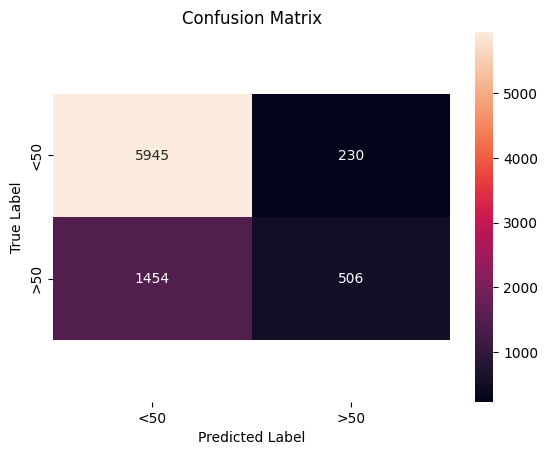

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_label = ["<50", ">50"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
y_pred_proba = clf.predict_proba(X_test)

In [ ]:
roc_auc_score(y_test, y_pred_proba[:, 1])

0.5713913079401802

# Часть 2. Отбор признаков

1. Исследуйте четыре метода отбора признаков
2. Дайте оценку полученным результатам



## Метод 1

In [ ]:
numeric_names = numeric_features
categorical_names = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_names, categorical_names])

coef = clf.named_steps['classifier'].coef_[0]

top_40_indices = np.argsort(np.abs(coef))[-40:]
top_40_features = feature_names[top_40_indices]

In [ ]:
selected_features_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [f for f in numeric_features if f in top_40_features]),
        ('cat', categorical_transformer, [f for f in categorical_features if any(f in feature for feature in top_40_features)])])

clf_selected = Pipeline(steps=[('preprocessor', selected_features_transformer),
                               ('classifier', LogisticRegression(max_iter=1000))])

clf_selected.fit(X_train, y_train)

y_pred_selected = clf_selected.predict(X_test)
y_pred_proba_selected = clf_selected.predict_proba(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
print("Classification Report for Selected Features:\n", classification_report(y_test, y_pred_selected))
print("ROC-AUC Score for Selected Features:", roc_auc_score(y_test, y_pred_proba_selected[:, 1]))

Classification Report for Selected Features:
               precision    recall  f1-score   support

           0       0.88      0.93      0.91      6175
           1       0.74      0.60      0.66      1960

    accuracy                           0.85      8135
   macro avg       0.81      0.77      0.78      8135
weighted avg       0.85      0.85      0.85      8135

ROC-AUC Score for Selected Features: 0.9087402296951169


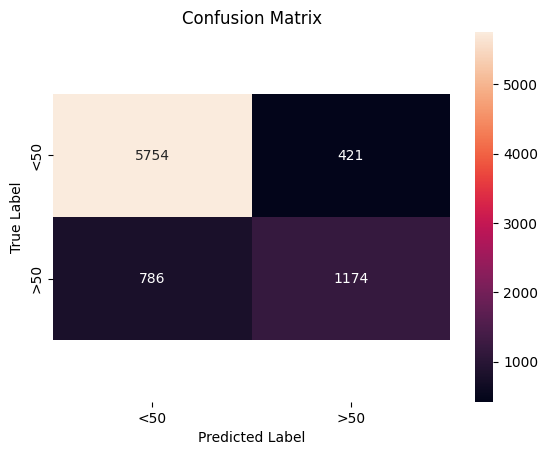

In [ ]:
cm = confusion_matrix(y_test, y_pred_selected)

class_label = ["<50", ">50"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# def create_new_features(data):
#   result = data.copy()
#   for fea in top_features:
#     if fea not in result.columns:
#       col, condition = fea.split()
#       result.loc[:, fea] = result[col[:-1]].apply(lambda x: 1 if x == f' {condition}' else 0)

#   return result

## Метод 2

In [ ]:
t_stats = []
for column in X.columns:
  group1 = X[column][y == 0]
  group2 = X[column][y == 1]

  group1 = pd.to_numeric(group1, errors='coerce')
  group2 = pd.to_numeric(group2, errors='coerce')

  t_stat, _ = stats.ttest_ind(group1, group2, equal_var=False)
  t_stats.append(abs(t_stat))

feature_importances = pd.DataFrame({
'Feature': X.columns,
'T-Statistic': t_stats
})

feature_importances = feature_importances.reindex(feature_importances['T-Statistic'].sort_values(ascending=False).index).head(40)

In [ ]:
feature_importances = feature_importances.dropna()
feature_importances

,Feature,T-Statistic
4,education-num,64.876078
0,age,50.235026
12,hours-per-week,45.095026
10,capital-gain,23.426145
11,capital-loss,20.232907
2,fnlwgt,1.747800


In [ ]:
selected_features_transformer = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, [f for f in numeric_features if f in list(feature_importances['Feature'])]),
        ('cat', categorical_transformer, [f for f in categorical_features if any(f in feature for feature in list(feature_importances['Feature']))])])

clf_selected = Pipeline(steps=[('preprocessor', selected_features_transformer),
                               ('classifier', LogisticRegression(max_iter=1000))])

clf_selected.fit(X_train, y_train)

y_pred_selected = clf_selected.predict(X_test)
y_pred_proba_selected = clf_selected.predict_proba(X_test)

In [ ]:
print("Classification Report for Selected Features:\n", classification_report(y_test, y_pred_selected))
print("ROC-AUC Score for Selected Features:", roc_auc_score(y_test, y_pred_proba_selected[:, 1]))

Classification Report for Selected Features:
               precision    recall  f1-score   support

           0       0.80      0.96      0.88      6175
           1       0.69      0.26      0.38      1960

    accuracy                           0.79      8135
   macro avg       0.75      0.61      0.63      8135
weighted avg       0.78      0.79      0.76      8135

ROC-AUC Score for Selected Features: 0.571673345451541


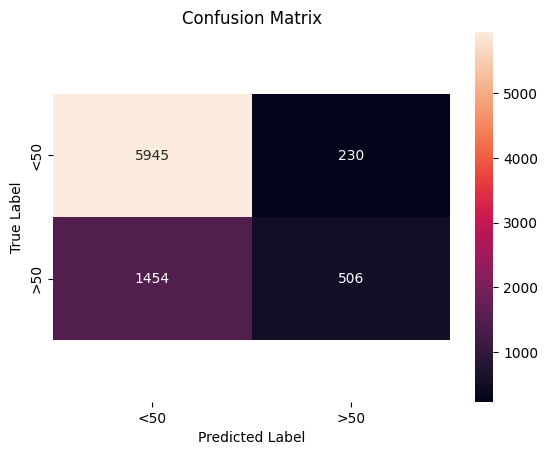

In [ ]:
cm = confusion_matrix(y_test, y_pred_selected)

class_label = ["<50", ">50"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Метод 3

In [ ]:
numeric_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=32)

rfe = RFE(estimator=model, n_features_to_select=40, step=1)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['age', 'fnlwgt',
                                                   'education-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('feature_selection',
                 RFE(estimator=LogisticRegression(max_iter=1000,
                                                  random_state=32),
                     n_features_to_select=40)),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=32))])

In [ ]:
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [ ]:
print("Classification Report for Selected Features:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score for Selected Features:", roc_auc_score(y_test, y_proba))

Classification Report for Selected Features:
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      6175
           1       0.70      0.54      0.61      1960

    accuracy                           0.83      8135
   macro avg       0.78      0.73      0.75      8135
weighted avg       0.82      0.83      0.83      8135

ROC-AUC Score for Selected Features: 0.8840406097661736


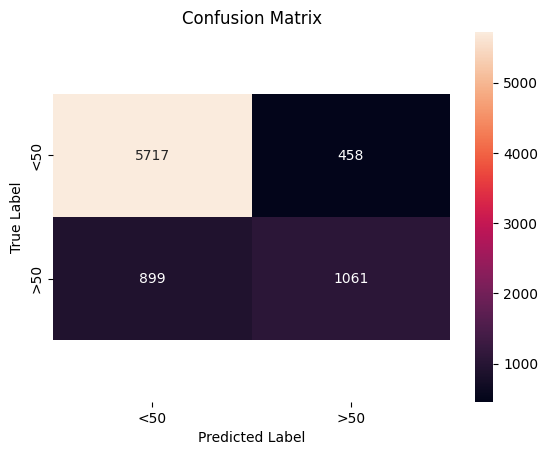

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_label = ["<50", ">50"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Метод 4

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

encoded_cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(encoded_cat_features)

lasso = LassoCV(cv=5, random_state=32)
lasso.fit(X_train_transformed, y_train)

LassoCV(cv=5, random_state=32)

In [ ]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

encoded_cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(encoded_cat_features)

lasso = LassoCV(cv=5, random_state=32)
lasso.fit(X_train_transformed, y_train)

selected_features = [feature for feature, coef in zip(feature_names, lasso.coef_) if coef != 0]
print("Selected Features: ", selected_features)

Selected Features:  ['age', 'fnlwgt', 'capital-gain', 'capital-loss', 'hours-per-week']


In [ ]:
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
selected_numerical_features = [feature for feature in numeric_features if feature in selected_features]
selected_categorical_features = [feature for feature in categorical_features if any(feature in sf for sf in selected_features)]

preprocessor_selected = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, selected_numerical_features),
        ('cat', categorical_transformer, selected_categorical_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_selected),
    ('classifier', LogisticRegression(max_iter=1000, random_state=32))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

In [ ]:
print("Classification Report for Selected Features:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score for Selected Features:", roc_auc_score(y_test, y_proba))

Classification Report for Selected Features:
               precision    recall  f1-score   support

           0       0.80      0.96      0.88      6175
           1       0.69      0.26      0.38      1960

    accuracy                           0.79      8135
   macro avg       0.75      0.61      0.63      8135
weighted avg       0.78      0.79      0.76      8135

ROC-AUC Score for Selected Features: 0.5724424109724862


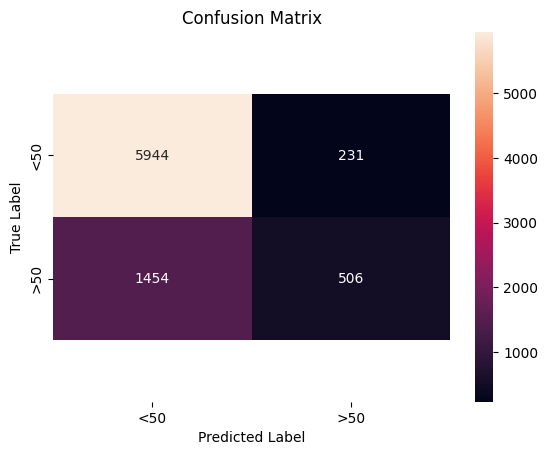

In [ ]:
cm = confusion_matrix(y_test, y_pred)

class_label = ["<50", ">50"]
df_cm = pd.DataFrame(cm, index=class_label,columns=class_label)
ax = sns.heatmap(df_cm, annot=True, fmt='d')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()